In [13]:
#___________________________________________________________________________________________________________________
# # get_ipython().magic('matplotlib notebook')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
# %matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import tripyview as tpv
import cartopy.crs              as ccrs
import cartopy.feature          as cfeature
from   cartopy.mpl.ticker       import (LongitudeFormatter, LatitudeFormatter)
from   cartopy.mpl.gridliner    import Gridliner
import matplotlib.pyplot        as plt
from   matplotlib.tri           import Triangulation,TriAnalyzer
import matplotlib.ticker        as mticker
import matplotlib.path          as mpath
import matplotlib.colors        as mcolors
from   matplotlib.colors        import ListedColormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Parameters
mesh_path ='/home/pscholz/FESOM2.0/meshes/core2/'
save_path = '~/Python/tripyview/RESULTS/plot_3dsphere/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 3
which_mode= '3dsphere'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append(None)

input_names= list()
input_names.append('')

vname     = 'eresol'  #'n_resol'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, 100

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
do_clim   = False
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cmap      = 'rygbw'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
ncolumn       = 1 
do_rescale    = True
which_dpi     = 300
#_____________________________________________________________________________________
do_potatoefac = 0.5 # 0.6
do_topo       = False
do_nlinrescal = True 

In [78]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        if ipath is not None: 
            input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
#______________________________________________________________________________________________________
cinfo=dict({'cstr':cmap, 'cnum':cnum})     
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

 > found *.pckl file: /home/pscholz/FESOM2.0/meshes/core2
 > load  *.pckl file: tripyview_fesom2_core2_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /home/pscholz/FESOM2.0/meshes/core2
 > id              = core2
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [79]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    if depth =='bottom':
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=None, descript=ref_name, do_info=False) 
        data_ref = data_ref.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=depth, descript=ref_name, do_info=False) 

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    if depth =='bottom':
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                      depth=None, descript=descript, do_info=False) 
        data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                      depth=depth, descript=descript, do_info=False) 
    #__________________________________________________________________________________________________    
    if ref_path is not None:
        data_list.append(do_anomaly(data, data_ref))  
    else:
        data_list.append(data)  
    del(data)
    
if ref_path is not None: del(data_ref)    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth == 'bottom') and do_clim and (ref_path is None): 
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    data_list.append(clim)    
    del(clim)

None


In [80]:
var = list(data_list[0].keys())[0]
print(data_list[0][var].values.max())
print(data_list[0][var].values.min())

148.93603351584667
13.360704261568923


In [81]:
if do_nlinrescal:
    import copy as cp 
    # rescale resolusion nonlinear
    if 'resol' in vname:
        rescaling_vec = np.array([0,20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130,140,250])
        var = list(data_list[0].keys())[0]
        data_listrescal = cp.deepcopy(data_list)
        for ii in range(1,rescaling_vec.size-1):
            if ii==1:
                idx = np.where( data_list[0][var]<rescaling_vec[ii] )[0]
                data_listrescal[0][var].data[idx]=ii
            else:    
                idx = np.where( (data_list[0][var]>=rescaling_vec[ii-1]) & (data_list[0][var]<rescaling_vec[ii]) )[0]
                data_listrescal[0][var].data[idx]=ii + (data_listrescal[0][var].data[idx]-rescaling_vec[ii])/(rescaling_vec[ii]-rescaling_vec[ii-1])

            if ii == rescaling_vec.size-2:
                idx = np.where( data_list[0][var]>=rescaling_vec[ii] )[0]
                data_listrescal[0][var].data[idx]=ii
        data_list = data_listrescal
        print(data_list[0][var].values.max())
        print(data_list[0][var].values.min())

17.0
1.0


{'cstr': 'rygbw', 'cnum': 18, 'crange': [0, 18, 10.0], 'chist': True, 'ctresh': 0.995, 'cmin': 0, 'cmax': 18, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f8dfba6d700>, 'clevel': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])}
 > save figure: /home/pscholz/Python/tripyview/RESULTS/plot_3dsphere/image_2dsphere_nresol_lon115_lat000.png


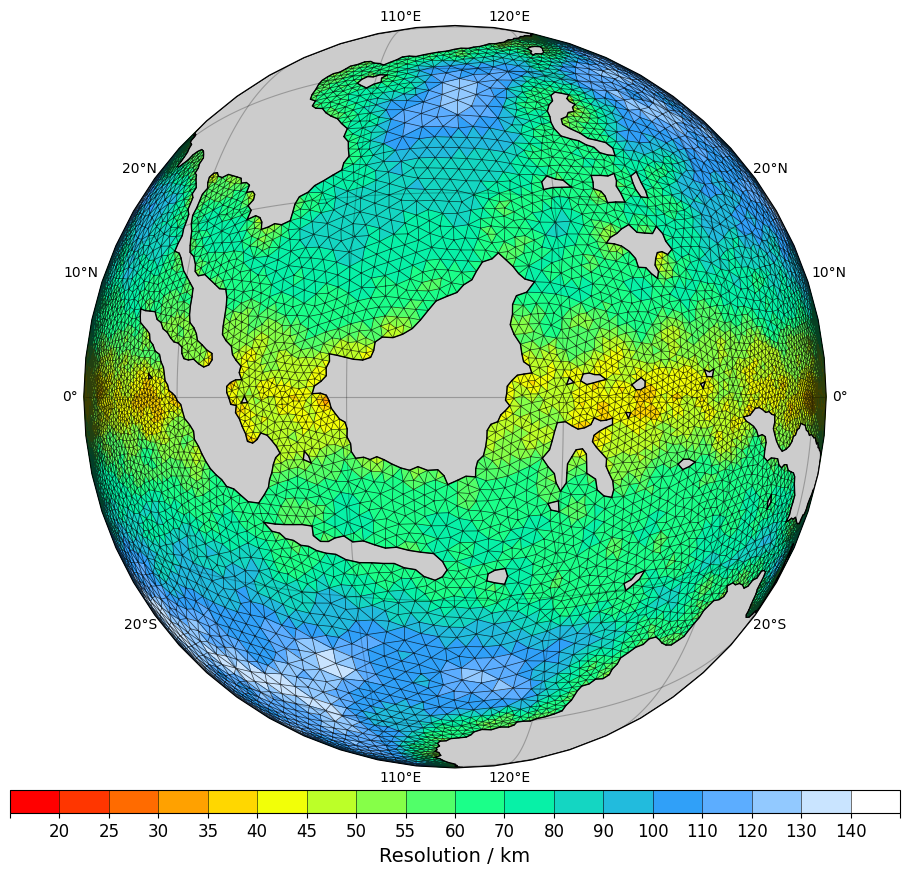

In [84]:
init_lon, init_lat, zoom = 115, 0, 30 

which_proj=ccrs.NearsidePerspective(central_longitude=init_lon, 
                                    central_latitude=init_lat, 
                                    satellite_height=35785831.0/zoom )
which_transf = ccrs.PlateCarree()   

#___________________________________________________________________________    
# create figure and axes
fig, ax = plt.subplots( 1 , 1,
                        figsize=[10,10], 
                        subplot_kw =dict(projection=which_proj),
                        gridspec_kw=dict(left=0.06, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.05,),
                        constrained_layout=False, )
#___________________________________________________________________________
# create mesh triangulation
tri = Triangulation(np.hstack((mesh.n_x,mesh.n_xa)),
                    np.hstack((mesh.n_y,mesh.n_ya)),
                    np.vstack((mesh.e_i[mesh.e_pbnd_0,:],mesh.e_ia)))
                                    
cinfo['cstr'  ] = 'rygbw'
cinfo['crange'] = [0, rescaling_vec.size-1, np.ceil(rescaling_vec.size/2)]
cinfo['cnum'  ] = rescaling_vec.size-1
cinfo = tpv.do_setupcinfo(cinfo, data_list, None, mesh, False)
clim = [cinfo['clevel'][0],cinfo['clevel'][-1]]

#_______________________________________________________________________
# remap coordinates 
mappoints = which_proj.transform_points(which_transf, tri.x, tri.y)
                      
#_______________________________________________________________________
# plot data
vname     = list(data_list[0].keys())[0]
data_plot = data_list[0][vname].data.copy() 
if 'nod2' in data_list[0].dims:
    data_plot = np.hstack((data_plot,data_plot[mesh.n_pbnd_a]))     
if 'elem' in data_list[0].dims:    
    data_plot = np.hstack((data_plot[mesh.e_pbnd_0],data_plot[mesh.e_pbnd_a]))
    
hp=ax.tripcolor(mappoints[:,0], mappoints[:,1], tri.triangles[:,:], data_plot,
                shading='flat',
                cmap=cinfo['cmap'],
                vmin=cinfo['clevel'][0], vmax=cinfo['clevel'][ -1]) #transform=which_transf, 
#_______________________________________________________________________
# plot mesh 
ax.triplot(mappoints[:,0], mappoints[:,1], tri.triangles[:,:], color='k', linewidth=0.5, alpha=0.75,zorder=5)
#_______________________________________________________________________
# plot lsmask
ax.add_geometries(mesh.lsmask_p, crs=ccrs.PlateCarree(), facecolor=[0.8,0.8,0.8], edgecolor='k' ,linewidth=1)
ax.gridlines(color='black', linestyle='-', draw_labels=True, alpha=0.25, )
#_______________________________________________________________________
# plot colorbar 
cbar = plt.colorbar(hp, orientation='horizontal', ax=ax, ticks=cinfo['clevel'],  
                        extendrect=False, extendfrac=None,
                        drawedges=True, pad=0.025, shrink=1.0, aspect=40)                      

tlabels = [str(val) for val in rescaling_vec]
tlabels[0],tlabels[-1] = '',''
cbar.ax.set_xticklabels(tlabels, fontsize=12)
cbar.set_label('Resolution / km', size=12+2)

#_______________________________________________________________________
# save plot 
fname = 'image_2dsphere_{:s}_lon{:03d}_lat{:03d}.png'.format(vname, init_lon, init_lat)
tpv.do_savefigure(os.path.join(save_path,fname), fig, dpi=300, transparent=True)